Install PyTrochVideo from git:

To install pytorchvideo from git, uncomment below cell and run it.

In [ ]:
  # !pip install git+https://github.com/facebookresearch/pytorchvideo.git

# 1. CLASSIFICATION:

## Running a pre-trained PyTorchVideo classification model using Torch Hub:

PyTorchVideo provides several pretrained models through Torch Hub. In this tutorial we will show how to load a pre trained video classification model in PyTorchVideo and run it on a test video. The PyTorchVideo Torch Hub models were trained on the Kinetics 400 dataset

### 1. Imports

In [ ]:
import torch
import json
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict

### 2. Load Model
Let's select the `slowfast_r50` model which was trained on the Kinetics 400 dataset.

In [4]:
# Device on which to run the model
# Set to cuda to load on GPU
device = "cuda"

# Pick a pretrained model and load the pretrained weights
model_name = "slowfast_r50"
model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)

# Set to eval mode and move to desired device
model = model.to(device)
model = model.eval()

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:01<00:00, 163MB/s]


### 3. Setup Labels

Next let's download the id-to-label mapping for the Kinetics 400 dataset on which the torch hub models were trained. This will be used to get the category label names from the predicted class ids.

In [5]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json

--2023-09-13 05:08:05--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.201.23, 108.156.201.112, 108.156.201.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.201.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0.001s  

2023-09-13 05:08:06 (18.9 MB/s) - ‘kinetics_classnames.json’ saved [10326/10326]



In [6]:
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

### 4. Input Transform:

Before passing the video into the model we need to apply some input transforms and sample a clip of the correct duration.

NOTE: The input transforms are specific to the model. If you choose a different model than the example in this tutorial, please refer to the code provided in the Torch Hub documentation and copy over the relevant transforms:
- [SlowFast](https://pytorch.org/hub/facebookresearch_pytorchvideo_slowfast/)
- [X3D](https://pytorch.org/hub/facebookresearch_pytorchvideo_x3d/)
- [Slow](https://pytorch.org/hub/facebookresearch_pytorchvideo_resnet/)

In [7]:
####################
# SlowFast transform
####################

side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

### 5. Load an example video:

We can now test the model with an example video from the Kinetics validation set such as this [archery video](https://www.youtube.com/watch?v=3and4vWkW4s).

Below you can see the content of the archery video

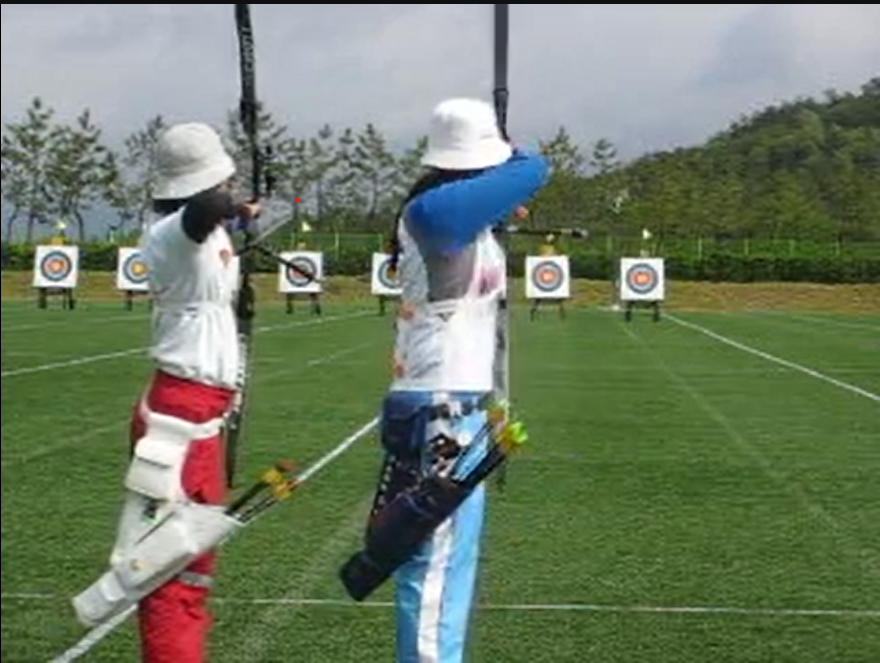

In [8]:
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4

--2023-09-13 05:09:00--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549197 (536K) [video/mp4]
Saving to: ‘archery.mp4’

archery.mp4         100%[===================>] 536.33K  --.-KB/s    in 0.04s   

2023-09-13 05:09:00 (11.8 MB/s) - ‘archery.mp4’ saved [549197/549197]



In [9]:
# Load the example video
video_path = "archery.mp4"

# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

### 6. Get model predictions:

Now we are ready to pass the input into the model and classify the action.

In [10]:
# Pass the input clip through the model
preds = model(inputs)

Let's look at the top 5 best predictions:

In [11]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
print("Predicted labels: %s" % ", ".join(pred_class_names))

Predicted labels: archery, throwing axe, playing paintball, disc golfing, riding or walking with horse
